In [1]:
suppressPackageStartupMessages(library("ridge"))
suppressPackageStartupMessages(library("sva"))
suppressPackageStartupMessages(library("car"))
suppressPackageStartupMessages(library("preprocessCore"))
suppressPackageStartupMessages(library("ROCR"))
suppressPackageStartupMessages(library("GEOquery"))
suppressPackageStartupMessages(library("MLmetrics"))
suppressPackageStartupMessages(library("PRROC"))
suppressPackageStartupMessages(library("plyr"))
source("../Geeleher_with_GDSCr6/scripts/compute_phenotype_function.R")
source("../Geeleher_with_GDSCr6/scripts/summarizeGenesByMean.R")
source("../Geeleher_with_GDSCr6/scripts/homogenize_data.R")
source("../Geeleher_with_GDSCr6/scripts/do_variable_selection.R")

In [6]:
root_dir <- "../v2/"
# You can play with the preprocessing but the following is what Geeleher et al. 2014 used:
powTransP=TRUE
lowVarGeneThr=0.2
# Number of permutations <---- not used  
NUM_PERM=10000



In [3]:
group_compare_plot <- function(predictedResp,knownRespGroups, 
                        plot_title="",plot_ylab="logIC50",cohort=""){
    # predictedResp is a list of predicted IC50 with sample names in names
    # knownRespGroups is a table with samples in rownames and column "response" with R and S
    R_samples <- row.names(knownRespGroups[knownRespGroups["response"] == "R",])
    S_samples <-  row.names(knownRespGroups[knownRespGroups["response"] == "S",])

    predictedRespGrouped <- list("Resistant"=predictedResp[R_samples],
                                  "Sensitive"=predictedResp[S_samples]) 
    
    boxplot(predictedRespGrouped, outline=FALSE, border="grey", 
            ylab="logIC50",
            main=plot_title)
    stripchart(predictedRespGrouped , vertical=TRUE, pch=20, method="jitter", add=TRUE)
    # T-test whether logIC50 in R is greater than in S group
    #ttest_res <- t.test(predictedRespGrouped$"Resistant",predictedRespGrouped$"Sensitive", alternative="greater")
    #cat(cohort,"\n\tT-test p-value:", ttest_res$p.value,
    #"\n\tCI95%:",ttest_res$conf.int,
    #"\n\tmeans:",ttest_res$estimate,"\n")
    return (predictedRespGrouped)
}

getAUC <- function(predictedRespGrouped,NUM_PERM=1000){
    # calculate AUC on the real data 
    predictedResp <- c(predictedRespGrouped$"Sensitive",predictedRespGrouped$"Resistant")
    cat(paste0("S:",length(predictedRespGrouped$"Sensitive")," R:",length(predictedRespGrouped$"Resistant")))
    trueResp <- c(rep("Sensitive", length(predictedRespGrouped$"Sensitive")), 
                  rep("Resistant", length(predictedRespGrouped$"Resistant")))
    
    predictionResult <- prediction(predictedResp, trueResp, label.ordering=c("Sensitive", "Resistant"))
    
    performanceObj <- performance(predictionResult, measure = "tpr", x.measure = "fpr")
    realDataAUC <- performance(predictionResult, measure = "auc")@"y.values"[[1]]
    cat(paste0("\nAUC:    ", realDataAUC,"\n"))
    
    # permute true response labels NUM_PERM and calculate AUCs
    AUCs <- numeric()
    for(i in 1:NUM_PERM)
    {
      # permute response labels
      permutedTrueResp <- sample(trueResp)
      predPerm <- prediction(predictedResp,permutedTrueResp,label.ordering=c("Sensitive", "Resistant"))
      AUCs[i] <- performance(predPerm, measure = "auc")@"y.values"[[1]]
    }
    permutationPvalue <- sum(AUCs  > realDataAUC)/NUM_PERM
    cat(paste0("ROC Permuatation p-value:    ", permutationPvalue,"\n"))
    cat(paste0("average AUC in permutations:    ", mean(AUCs),"\n"))
    return(list("performanceObj"=performanceObj,
                "AUC"=realDataAUC,"AUC_perm_avg"=mean(AUCs),"AUC_pval"=permutationPvalue,
                "S"=length(predictedRespGrouped$"Sensitive"),"R"=length(predictedRespGrouped$"Resistant")))
}

run_Geelehers_method <- function(testDataFile,testResponseFile,trainingDataFile,trainingResponseFile,
                       powTransP=TRUE,lowVarGeneThr=0.2,cohort=cohort,drug=drug){
    # read training data and reorder 
    trainingData <- read.csv(trainingDataFile, as.is=TRUE, check.names=FALSE,sep = "\t", row.names = 1, header= TRUE)
    trainingResponse <- read.csv(trainingResponseFile, as.is=TRUE, check.names=FALSE,sep = "\t", row.names = 1, header= TRUE)
    trainingData <- as.matrix(trainingData[,row.names(trainingResponse)])
    #trainingData <- 2^trainingData
    trainingI50 <- trainingResponse$logIC50
    names(trainingI50 ) <- rownames(trainingResponse)
    
    
    # read testing data and reorder 
    testData <- read.table(testDataFile,sep = "\t", row.names = 1, header= TRUE,as.is=TRUE, check.names=FALSE)
    testResponse <- read.csv(testResponseFile, as.is=TRUE, check.names=FALSE,sep = "\t", row.names = 1, header= TRUE)
    testData <- as.matrix(testData[,row.names(testResponse)])
    #testData <- 2^testData
    
    # statistics
    shared_genes = intersect(row.names(trainingData),row.names(testData))
    cat(paste0(cohort," ",drug,"\n"))
    cat(paste0("genes in training cohort: ", dim(trainingData)[1],"\tsamples: ", dim(trainingData)[2],"\n",
               "genes in testing cohort: ", dim(testData)[1],"\tsamples: ", dim(testData)[2],"\n",
               "shared:", length(shared_genes),"\n"))
    
    # predict response for testing cohort
    sink("/dev/null") 
    predictedIC50 <- suppressMessages(calcPhenotype(testData, trainingData, trainingI50,
                               powerTransformPhenotype=powTransP,
                               removeLowVaryingGenes=lowVarGeneThr,minNumSamples=2))
    sink()
    
    options(repr.plot.width=15, repr.plot.height=5)
    par(mfrow=c(1,4))

    sink("/dev/null") 
    tmp<-group_compare_plot(trainingI50,trainingResponse, 
                plot_title=paste0("Training: ","GDSC"),cohort = "GDSC")
    sink()
    tmp <-0
    
    # testing 
    predictedRespGrouped <- group_compare_plot(predictedIC50,testResponse, 
                plot_title=paste0("Prediction: ",cohort),cohort = cohort)

    # ROC curve and AUC
    AUC_list  <- getAUC(predictedRespGrouped,NUM_PERM=NUM_PERM)
    performanceObj  <- AUC_list$"performanceObj"
    plot(performanceObj, main=paste0("ROC ","for ",drug," in ",cohort))
    abline(0, 1, col="grey", lty=2)
    
    # area under PR curve
    AUPRC_list <- getAUPRC(predictedRespGrouped,NUM_PERM=NUM_PERM)

    cat("\n\n")
    return(
        c(list("predResp"=predictedRespGrouped,"trueResp"=testResponse),AUC_list,AUPRC_list))
    #return (list("testExprs"=testData,"testResp"=testResponse, 
    #                "trainingExprs"=trainingData,"trainingResp"=trainingResponse))
} 

getAUPRC <- function(predictedRespGrouped,NUM_PERM=1000){
    # calculate AUC on the real data 
    predictedResp <- c(predictedRespGrouped$"Sensitive",predictedRespGrouped$"Resistant")
    true_labels <- c(rep(1,length(predictedRespGrouped$"Sensitive")),rep(0,length(predictedRespGrouped$"Resistant")))
    
    pred_obj <- ROCR::prediction(predictedResp, true_labels)
    perf_obj <- ROCR::performance(pred_obj, measure = "prec", x.measure = "rec")
    ROCR::plot(perf_obj, ylim = c(0,1), xlim = c(0,1))

    #realDataAUPRC <- MLmetrics::PRAUC(y_pred = predictedResp, y_true = true_labels)
    realDataAUPRC <- PRROC::pr.curve(predictedResp,weights.class0 = true_labels)$auc.davis.goadrich
    cat(paste0("\nAUPRC:    ", realDataAUPRC,"\n"))
    
    # permute true response labels NUM_PERM and calculate AUCs
    AUPRCs <- numeric()
    for(i in 1:NUM_PERM)
    {
      # permute response labels
      permuted_labels <- sample(true_labels)
      AUPRCs[i] <- PRROC::pr.curve(predictedResp,weights.class0 = permuted_labels)$auc.davis.goadrich
      #  MLmetrics::PRAUC(y_pred = predictedResp, y_true = permuted_labels)
    }
    permutationPvalue <- sum(AUPRCs  > realDataAUPRC)/NUM_PERM
    cat(paste0("AUPRC Permuatation p-value:    ", permutationPvalue,"\n"))
    P_freq <- round(length(predictedRespGrouped$"Sensitive")/length(true_labels),2)
    cat(paste0("average AUPRC in permutations:    ", round(mean(AUPRCs),2),"; P/(P+N):",P_freq,"\n"))
    return(list("AUPRC"=realDataAUPRC,"AUPRC_perm_avg"=mean(AUPRCs),
                "AUPRC_pval"=permutationPvalue,"P_freq"=P_freq))
}

### Expression only

In [7]:
# Table 2 cohorts 
pairs <- list(list("drug"="Paclitaxel","cohort"="PDX"),
  list("drug"="Gemcitabine","cohort"="PDX"),
  list("drug"="Cetuximab","cohort"="PDX"),
  list("drug"="Erlotinib","cohort"="PDX"),
  list("drug"="Docetaxel","cohort"="TCGA"),
  list("drug"="Cisplatin","cohort"="TCGA"),
  list("drug"="Gemcitabine","cohort"="TCGA"))

PDX Paclitaxel
genes in training cohort: 18645	samples: 389
genes in testing cohort: 22443	samples: 43
shared:18232
S:5 R:38
AUC:    0,515789473684211
ROC Permuatation p-value:    0,4517
average AUC in permutations:    0,499441052631579

AUPRC:    0,101441793658113
AUPRC Permuatation p-value:    0,6791
average AUPRC in permutations:    0,15; P/(P+N):0,12


PDX Gemcitabine
genes in training cohort: 18645	samples: 844
genes in testing cohort: 22443	samples: 25
shared:18232
S:7 R:18
AUC:    0,587301587301587
ROC Permuatation p-value:    0,2449
average AUC in permutations:    0,4996


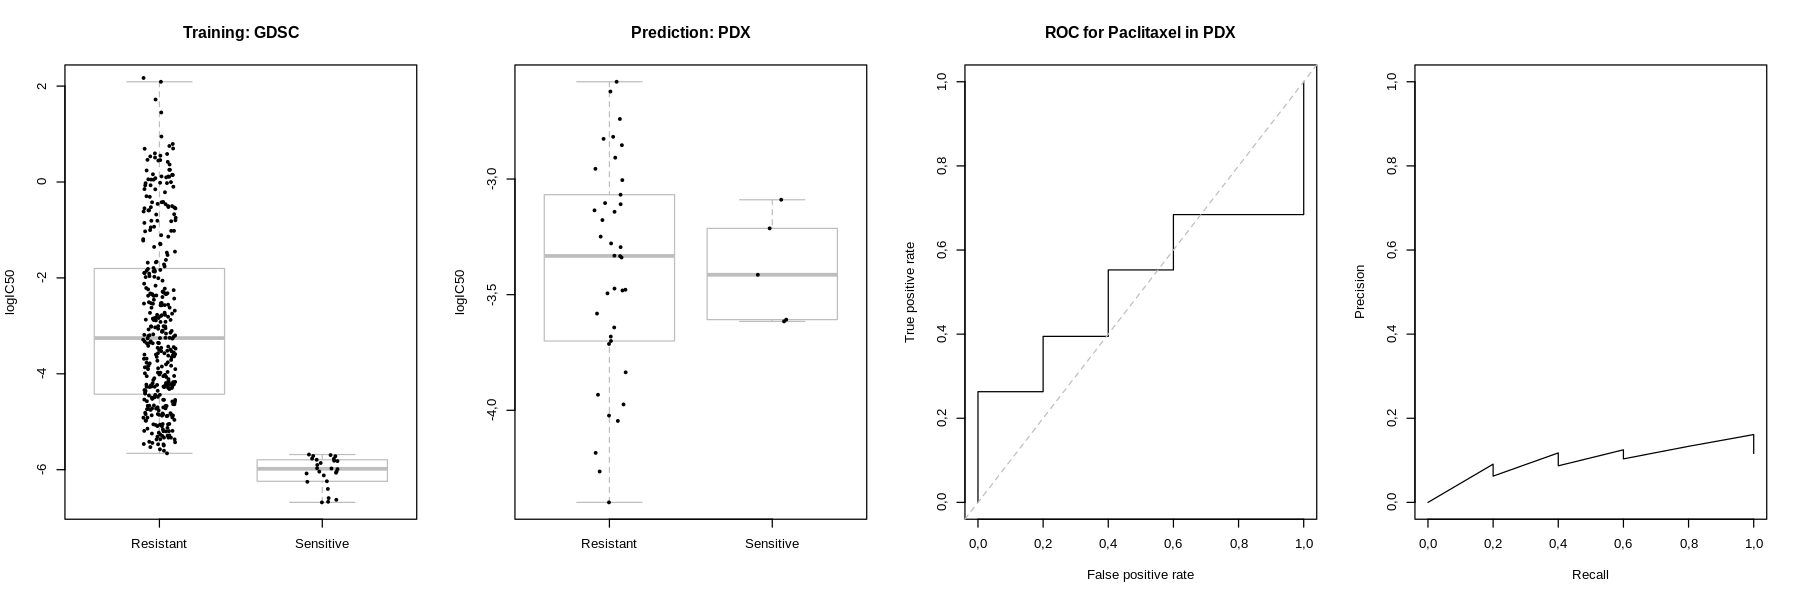


AUPRC:    0,275988073753876
AUPRC Permuatation p-value:    0,5498
average AUPRC in permutations:    0,32; P/(P+N):0,28


PDX Cetuximab
genes in training cohort: 18645	samples: 856
genes in testing cohort: 22443	samples: 60
shared:18232
S:5 R:55
AUC:    0,596363636363636
ROC Permuatation p-value:    0,2361
average AUC in permutations:    0,498114181818182


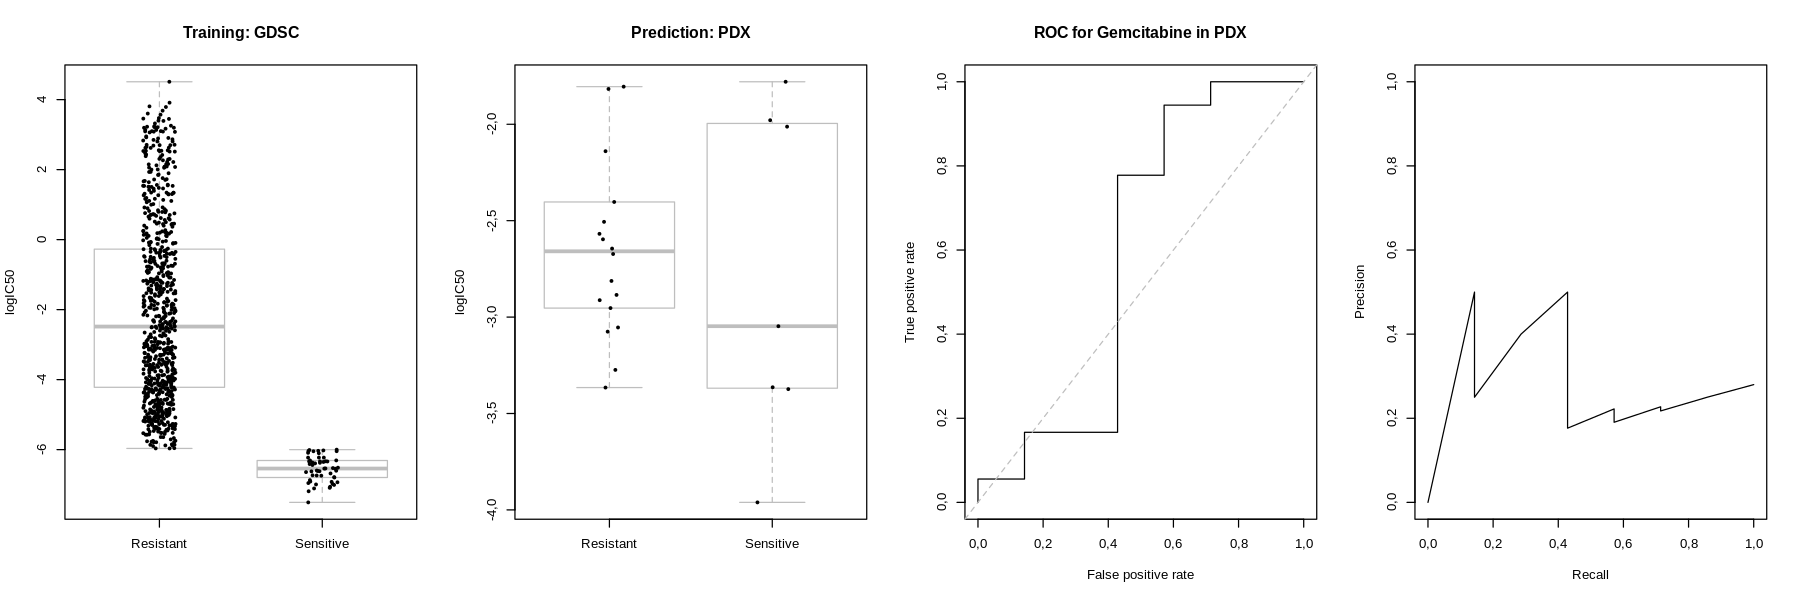


AUPRC:    0,0636468323300781
AUPRC Permuatation p-value:    0,8184
average AUPRC in permutations:    0,11; P/(P+N):0,08


PDX Erlotinib
genes in training cohort: 18645	samples: 362
genes in testing cohort: 22443	samples: 21
shared:18232
S:3 R:18
AUC:    0,666666666666667
ROC Permuatation p-value:    0,1781
average AUC in permutations:    0,500824074074074


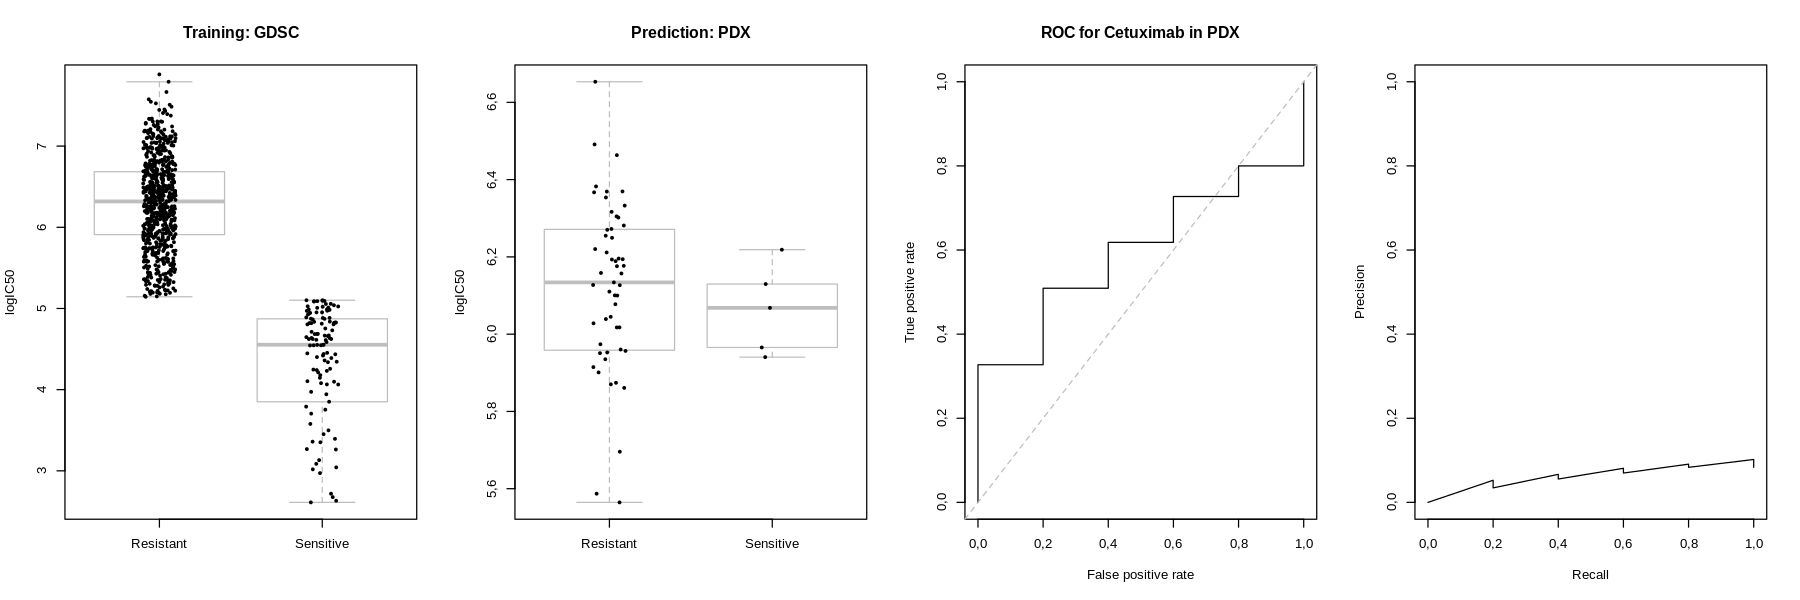


AUPRC:    0,112167366946779
AUPRC Permuatation p-value:    0,7269
average AUPRC in permutations:    0,2; P/(P+N):0,14


TCGA Docetaxel
genes in training cohort: 18645	samples: 829
genes in testing cohort: 20531	samples: 16
shared:18216
S:8 R:8
AUC:    0,59375
ROC Permuatation p-value:    0,2545
average AUC in permutations:    0,5004578125


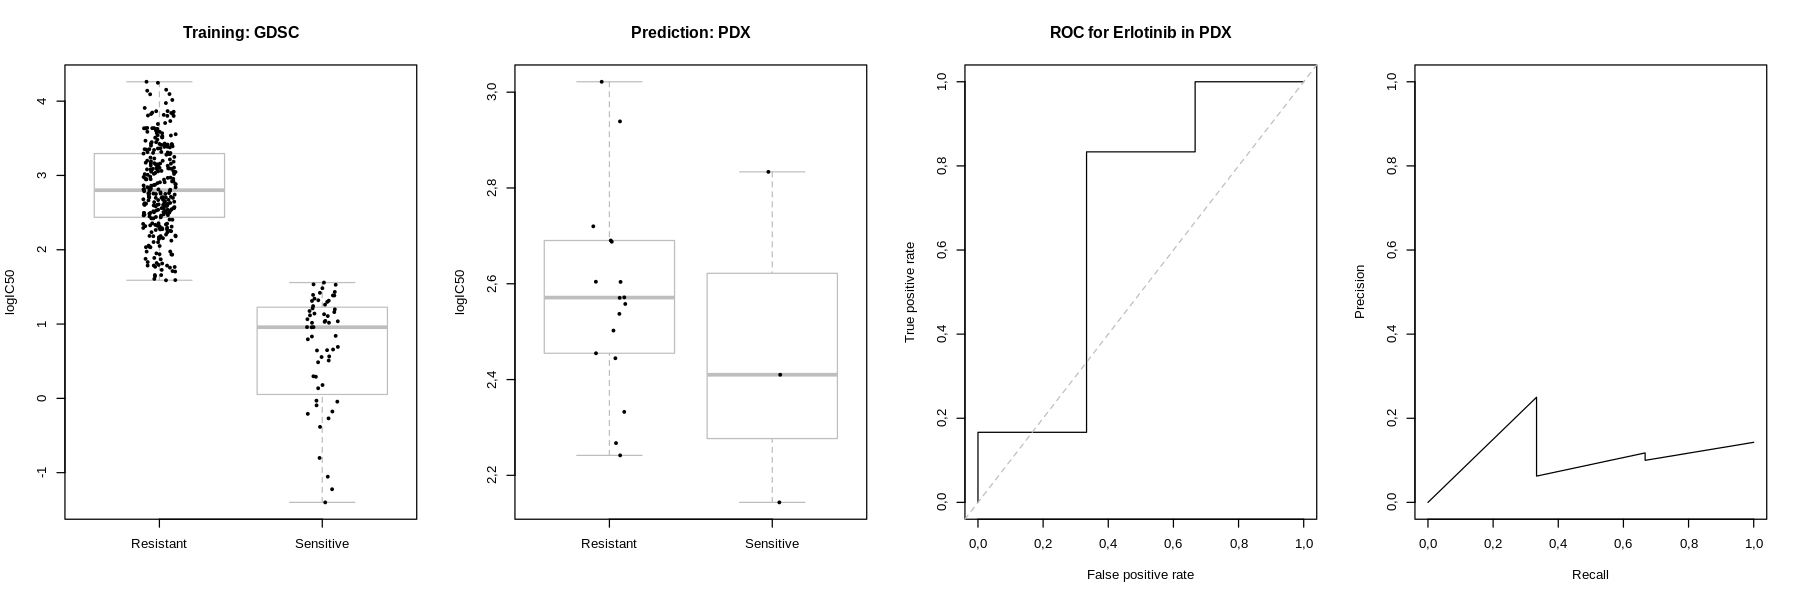


AUPRC:    0,508792943167943
AUPRC Permuatation p-value:    0,5501
average AUPRC in permutations:    0,54; P/(P+N):0,5


TCGA Cisplatin
genes in training cohort: 18645	samples: 829
genes in testing cohort: 20531	samples: 66
shared:18216
S:60 R:6
AUC:    0,622222222222222
ROC Permuatation p-value:    0,1702
average AUC in permutations:    0,50103


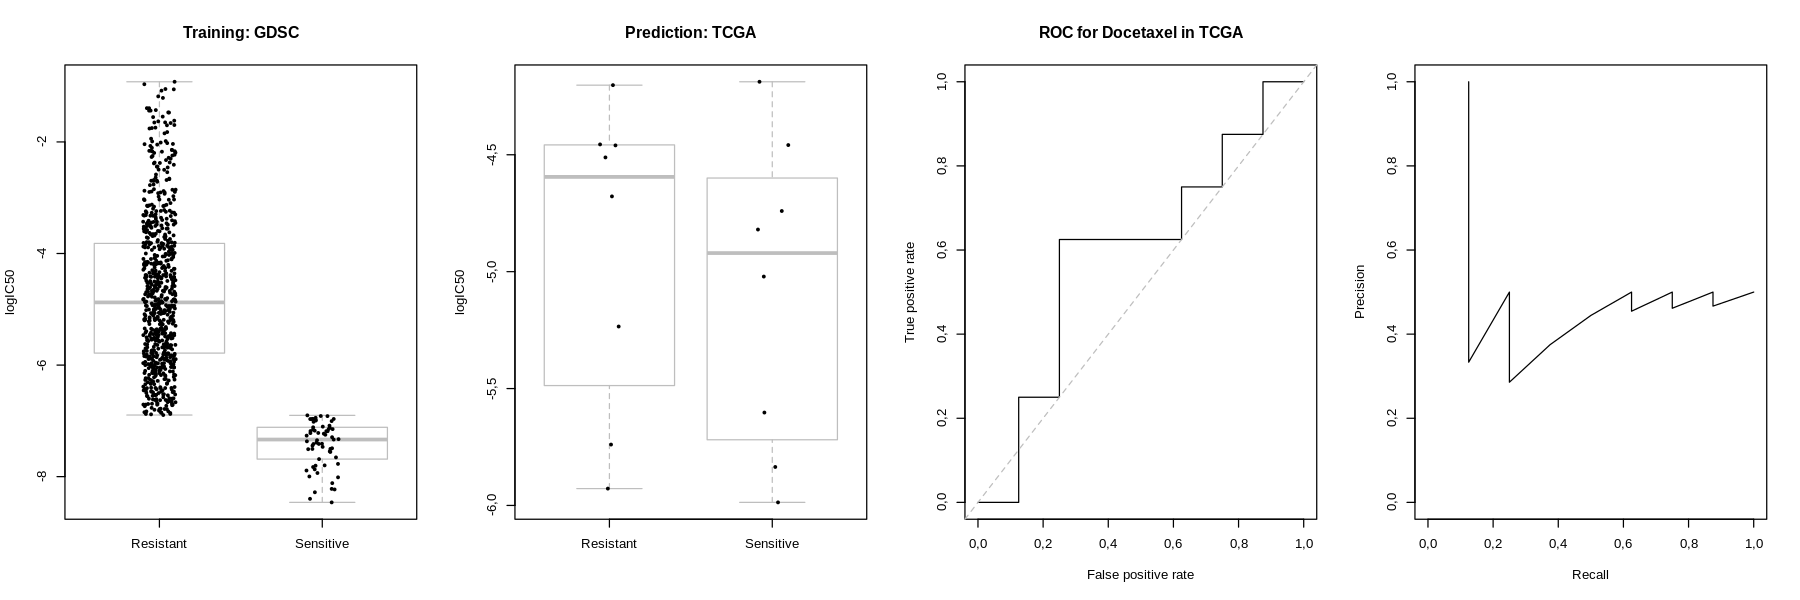


AUPRC:    0,848949199863794
AUPRC Permuatation p-value:    0,9573
average AUPRC in permutations:    0,91; P/(P+N):0,91


TCGA Gemcitabine
genes in training cohort: 18645	samples: 844
genes in testing cohort: 20531	samples: 57
shared:18216
S:21 R:36
AUC:    0,534391534391534
ROC Permuatation p-value:    0,3313
average AUC in permutations:    0,499637698412698


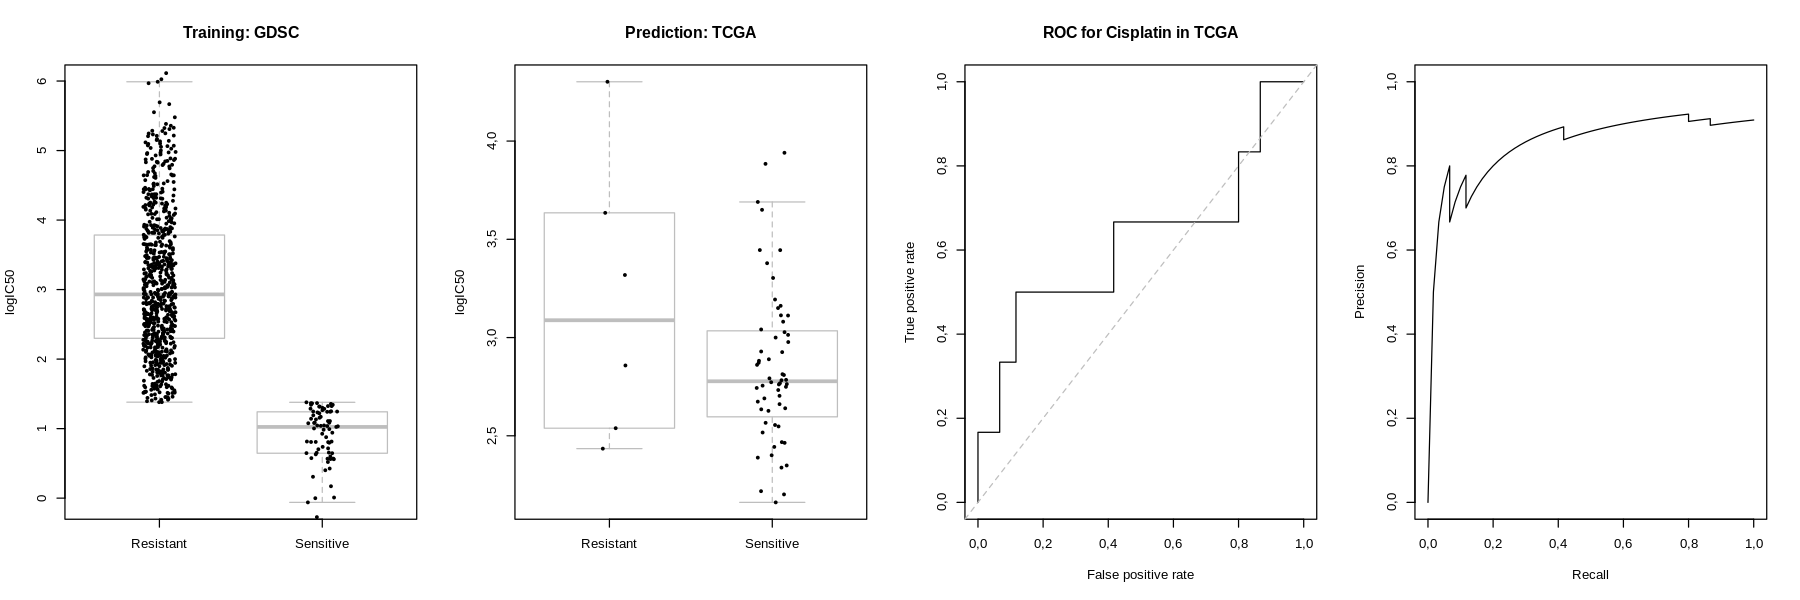


AUPRC:    0,381898250230817
AUPRC Permuatation p-value:    0,4812
average AUPRC in permutations:    0,39; P/(P+N):0,37




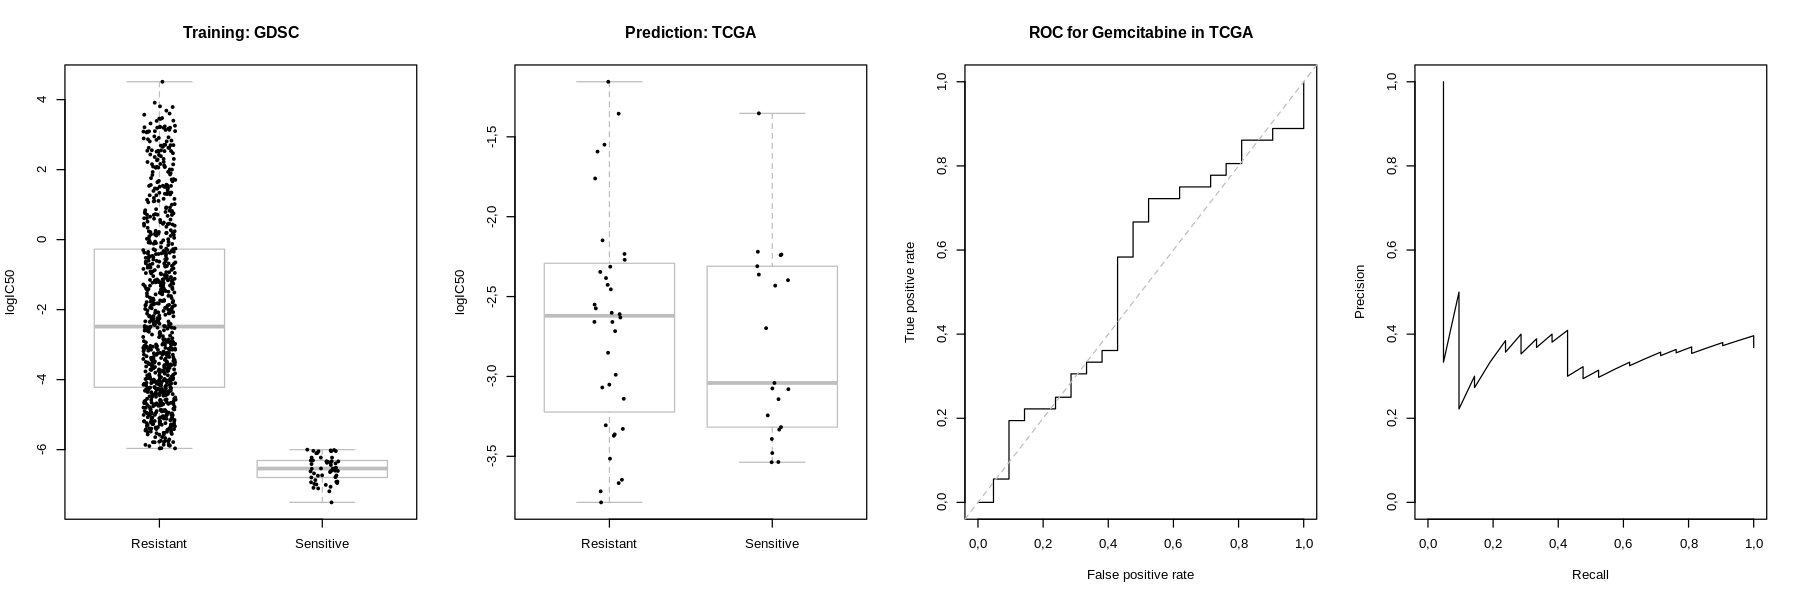

In [8]:

results_table <- list()
ds_names <- c()
for (pair in pairs){
    drug<- pair$"drug"
    cohort <- pair$"cohort"
    testDataFile <- paste0(root_dir,"/exprs/",cohort,"_exprs.",drug,".tsv")
    testResponseFile <- paste0(root_dir,"/response/",cohort,"_response.",drug,".tsv")

    trainingDataFile <- paste0(root_dir,"/exprs/","GDSC","_exprs.",drug,".tsv")
    trainingResponseFile <- paste0(root_dir,"/response/","GDSC","_response.",drug,".tsv")

    res <- run_Geelehers_method(testDataFile,testResponseFile,trainingDataFile,trainingResponseFile,
                           powTransP=powTransP,lowVarGeneThr=lowVarGeneThr,cohort=cohort,drug=drug)
    res <- c(res$"AUC",res$"AUC_pval",res$"AUPRC",res$"AUPRC_pval",res$"P_freq",res$"S",res$"R")
    ds_names <- c(ds_names, paste0(cohort,"_",drug))
    results_table  <- c(results_table , list(res))
}

results_table  <- plyr::ldply(results_table)
colnames(results_table) <- c("AUC","AUC_pval","AUPRC","AUPRC_pval","P_freq","S","R")
row.names(results_table) <-  ds_names


In [9]:
results_table 

,AUC,AUC_pval,AUPRC,AUPRC_pval,P_freq,S,R
PDX_Paclitaxel,"0,5157895","0,4517","0,10144179","0,6791","0,12",5,38
PDX_Gemcitabine,"0,5873016","0,2449","0,27598807","0,5498","0,28",7,18
PDX_Cetuximab,"0,5963636","0,2361","0,06364683","0,8184","0,08",5,55
PDX_Erlotinib,"0,6666667","0,1781","0,11216737","0,7269","0,14",3,18
TCGA_Docetaxel,"0,5937500","0,2545","0,50879294","0,5501","0,50",8,8
TCGA_Cisplatin,"0,6222222","0,1702","0,84894920","0,9573","0,91",60,6
TCGA_Gemcitabine,"0,5343915","0,3313","0,38189825","0,4812","0,37",21,36


### Multi-omics NMF-transoformed  k=96,128

[1] "NMF/PDX.multiOmics.Paclitaxel.NMF_k=80.W.tsv"
PDX Paclitaxel
genes in training cohort: 80	samples: 389
genes in testing cohort: 80	samples: 43
shared:80
S:5 R:38
AUC:    0,626315789473684
ROC Permuatation p-value:    0,1818
average AUC in permutations:    0,498177368421053

AUPRC:    0,0860629202713114
AUPRC Permuatation p-value:    0,8501
average AUPRC in permutations:    0,15; P/(P+N):0,12


[1] "NMF/PDX.multiOmics.Gemcitabine.NMF_k=80.W.tsv"
PDX Gemcitabine
genes in training cohort: 80	samples: 844
genes in testing cohort: 80	samples: 25
shared:80
S:7 R:18
AUC:    0,523809523809524
ROC Permuatation p-value:    0,4223
average AUC in permutations:    0,500869047619048


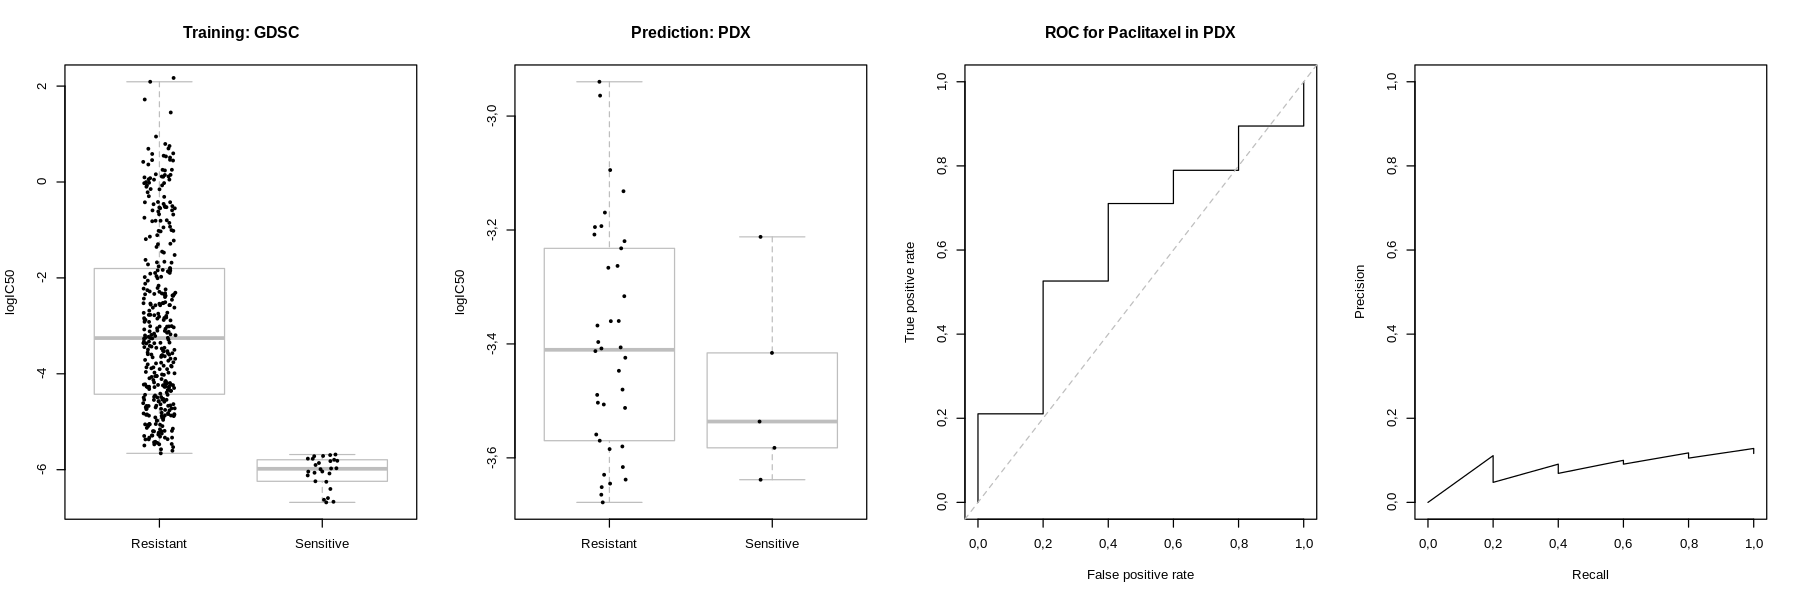


AUPRC:    0,373243520763135
AUPRC Permuatation p-value:    0,2715
average AUPRC in permutations:    0,32; P/(P+N):0,28


[1] "NMF/PDX.multiOmics.Cetuximab.NMF_k=80.W.tsv"
PDX Cetuximab
genes in training cohort: 80	samples: 856
genes in testing cohort: 80	samples: 60
shared:80
S:5 R:55
AUC:    0,385454545454545
ROC Permuatation p-value:    0,7956
average AUC in permutations:    0,500678545454545


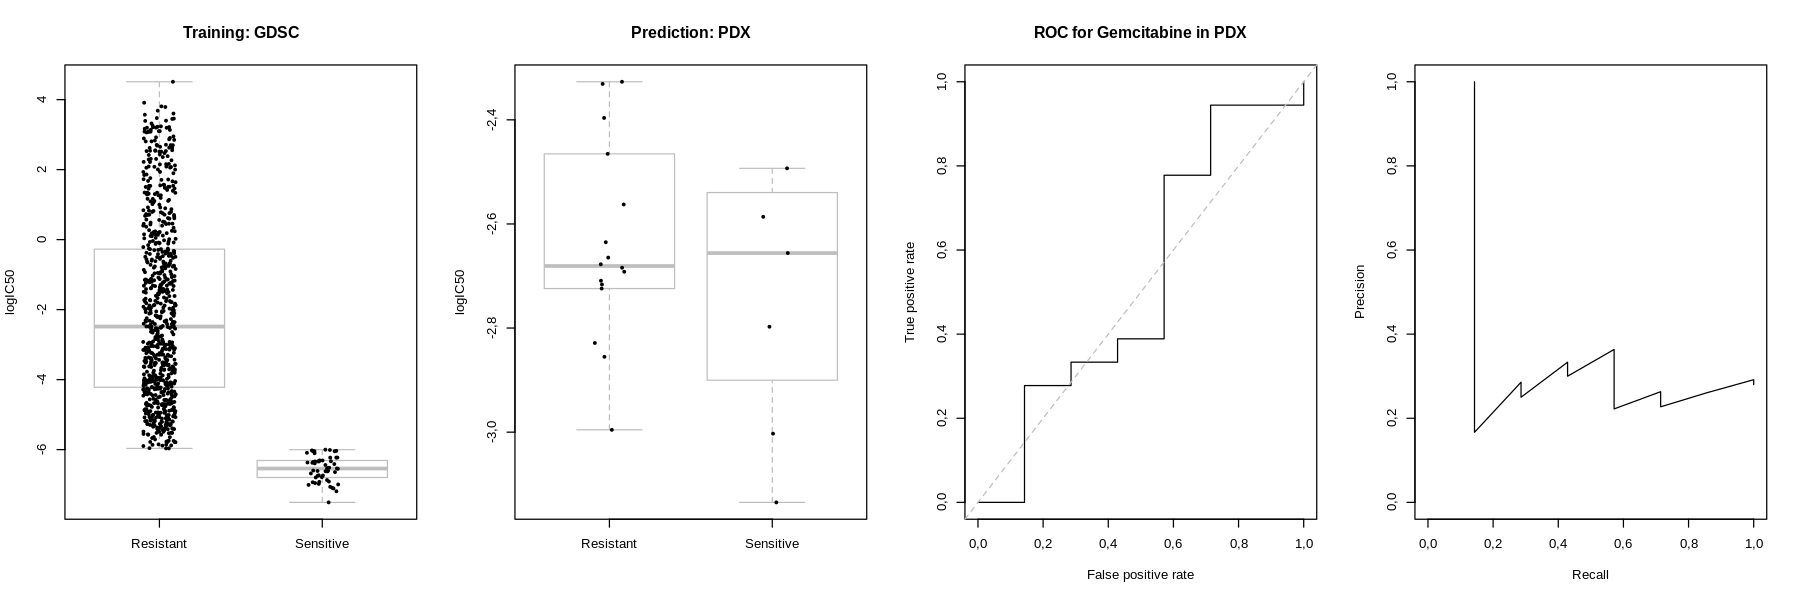


AUPRC:    0,107274315956612
AUPRC Permuatation p-value:    0,3216
average AUPRC in permutations:    0,11; P/(P+N):0,08


[1] "NMF/PDX.multiOmics.Erlotinib.NMF_k=80.W.tsv"
PDX Erlotinib
genes in training cohort: 80	samples: 362
genes in testing cohort: 80	samples: 21
shared:80
S:3 R:18
AUC:    0,407407407407407
ROC Permuatation p-value:    0,6598
average AUC in permutations:    0,500237037037037


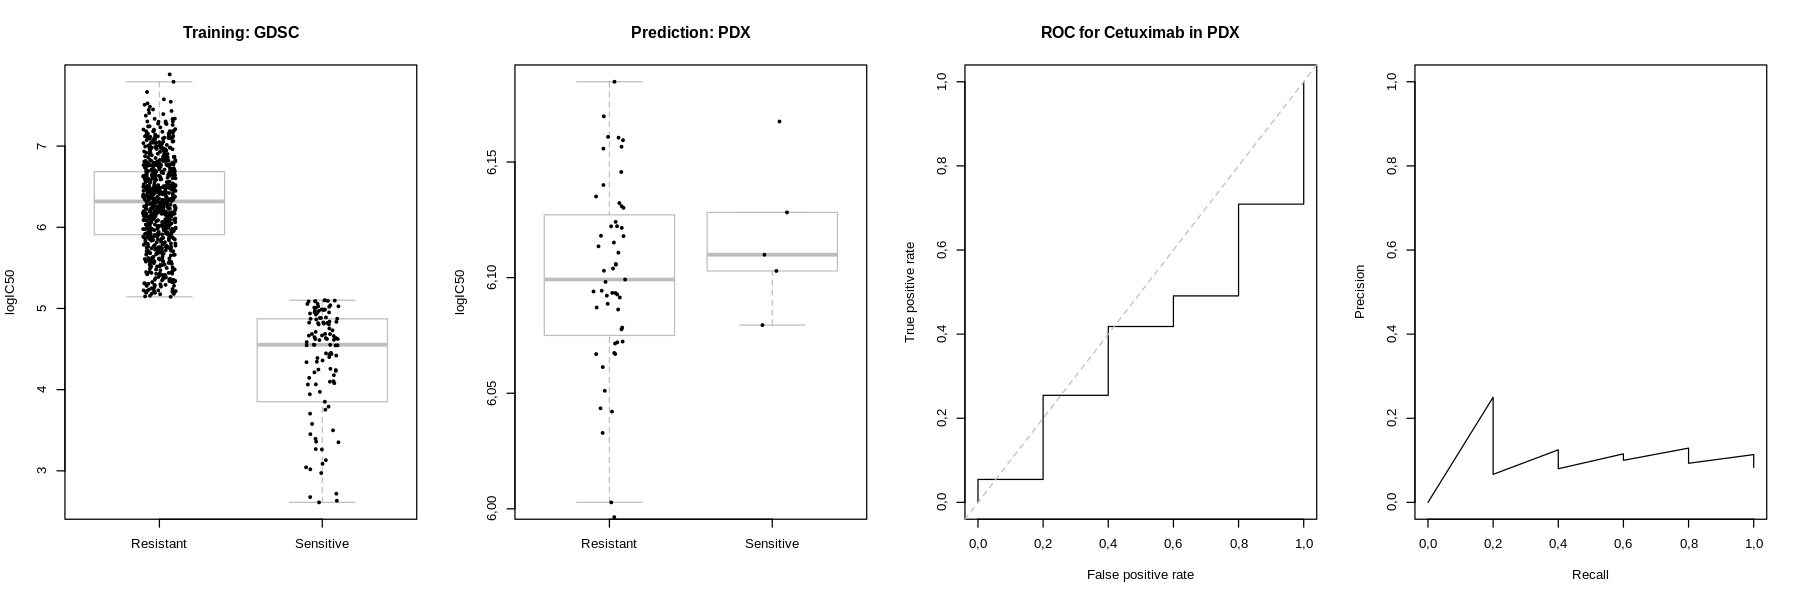


AUPRC:    0,15487567987568
AUPRC Permuatation p-value:    0,4468
average AUPRC in permutations:    0,2; P/(P+N):0,14


[1] "NMF/TCGA.multiOmics.Docetaxel.NMF_k=80.W.tsv"
TCGA Docetaxel
genes in training cohort: 80	samples: 829
genes in testing cohort: 80	samples: 16
shared:80
S:8 R:8
AUC:    0,546875
ROC Permuatation p-value:    0,363
average AUC in permutations:    0,4990984375


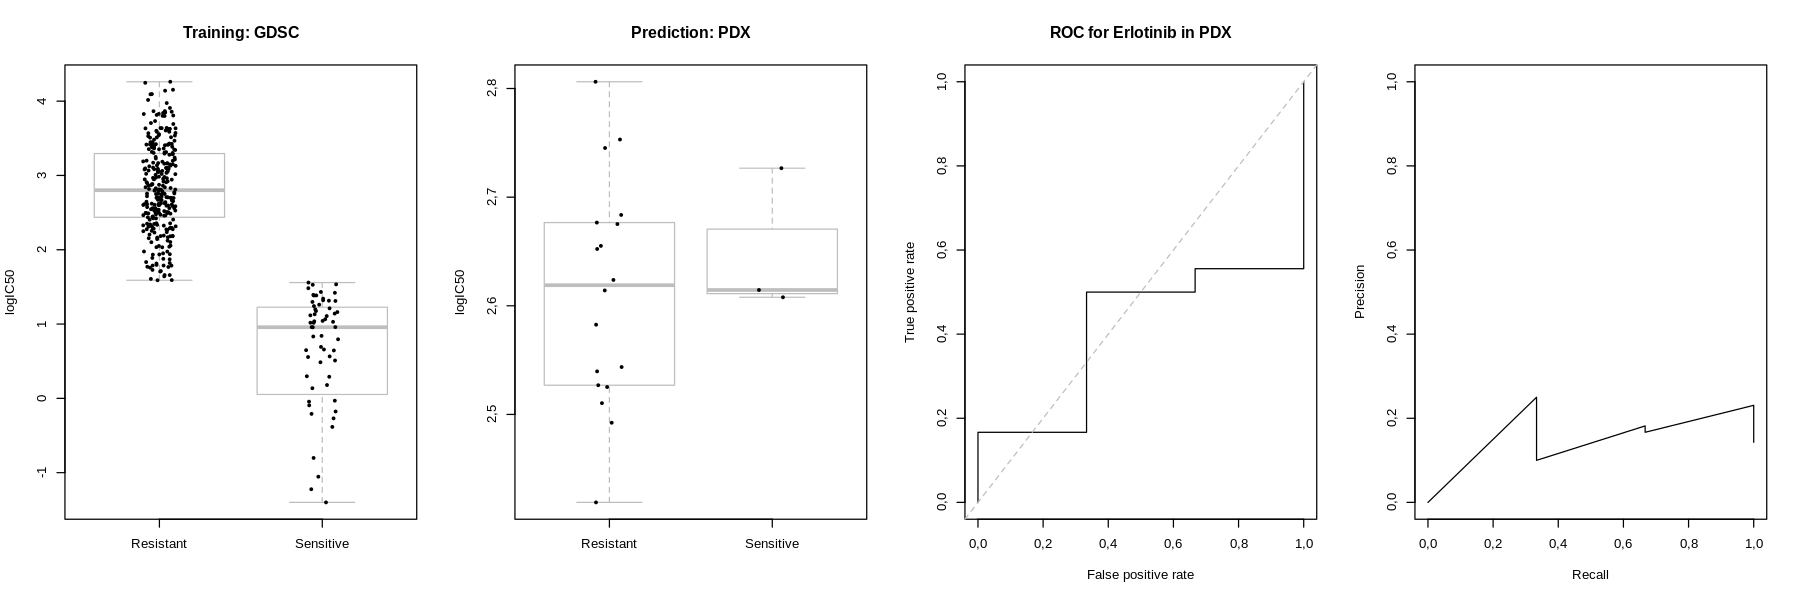


AUPRC:    0,53487293956044
AUPRC Permuatation p-value:    0,4553
average AUPRC in permutations:    0,54; P/(P+N):0,5


[1] "NMF/TCGA.multiOmics.Cisplatin.NMF_k=80.W.tsv"
TCGA Cisplatin
genes in training cohort: 80	samples: 829
genes in testing cohort: 80	samples: 66
shared:80
S:60 R:6
AUC:    0,477777777777778
ROC Permuatation p-value:    0,5785
average AUC in permutations:    0,500559722222222


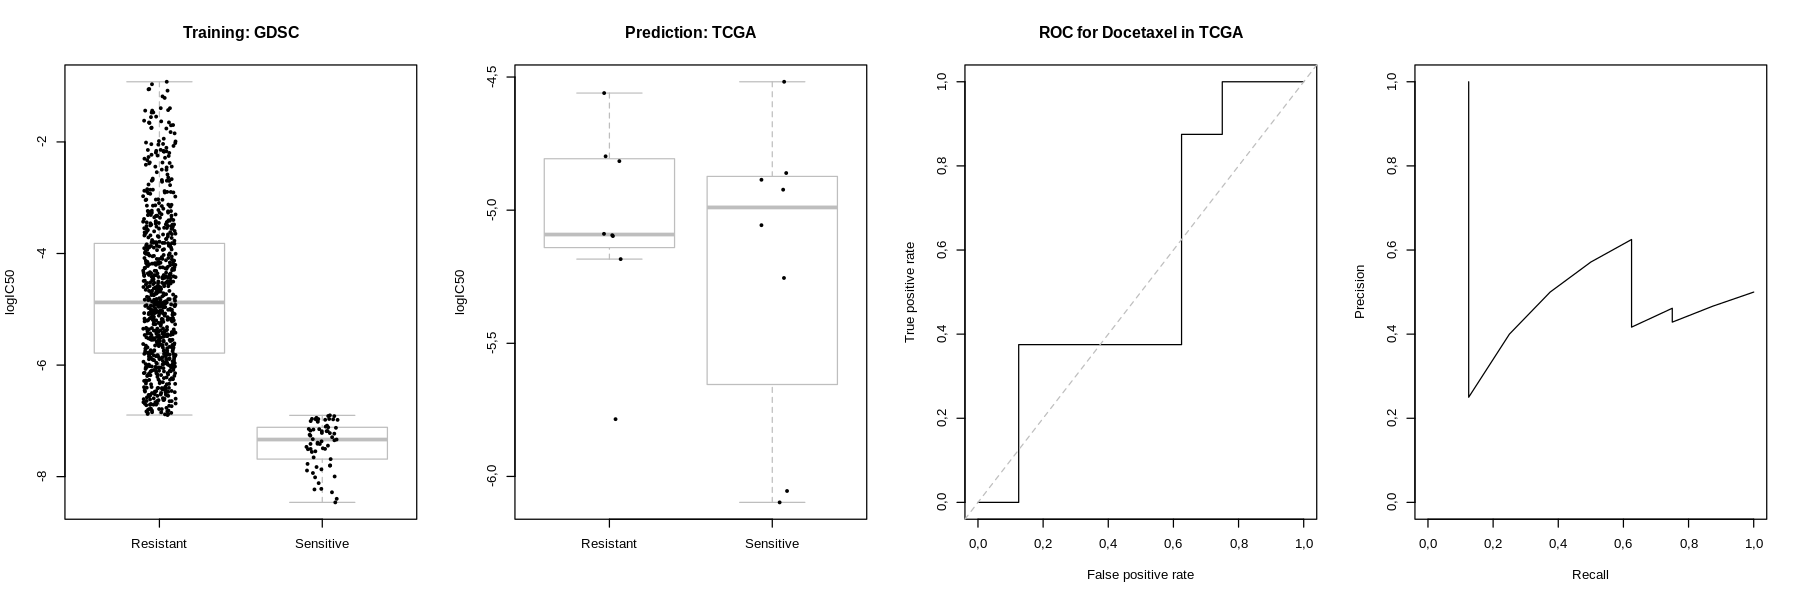


AUPRC:    0,899684449497925
AUPRC Permuatation p-value:    0,6581
average AUPRC in permutations:    0,91; P/(P+N):0,91


[1] "NMF/TCGA.multiOmics.Gemcitabine.NMF_k=80.W.tsv"
TCGA Gemcitabine
genes in training cohort: 80	samples: 844
genes in testing cohort: 80	samples: 57
shared:80
S:21 R:36
AUC:    0,534391534391534
ROC Permuatation p-value:    0,331
average AUC in permutations:    0,500372222222222


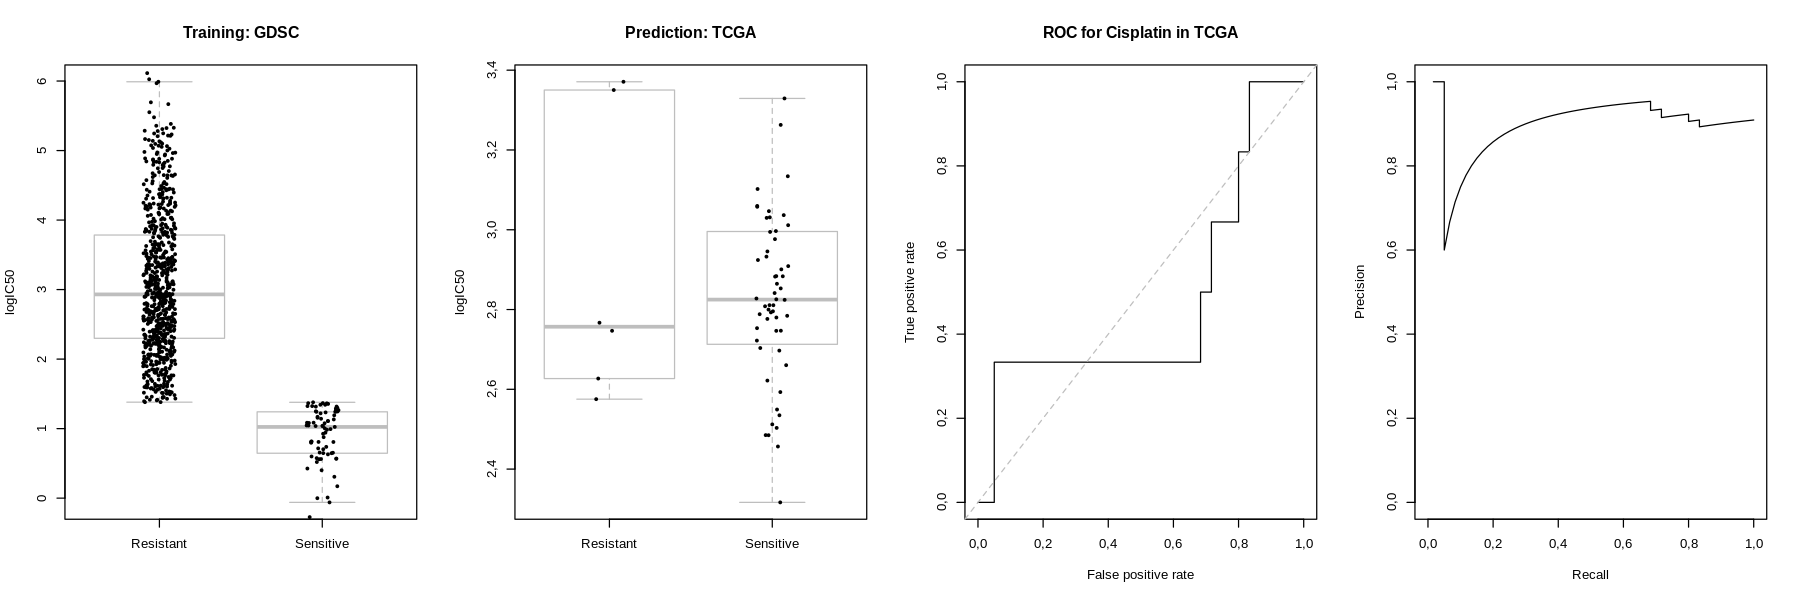


AUPRC:    0,334647220388673
AUPRC Permuatation p-value:    0,7661
average AUPRC in permutations:    0,39; P/(P+N):0,37




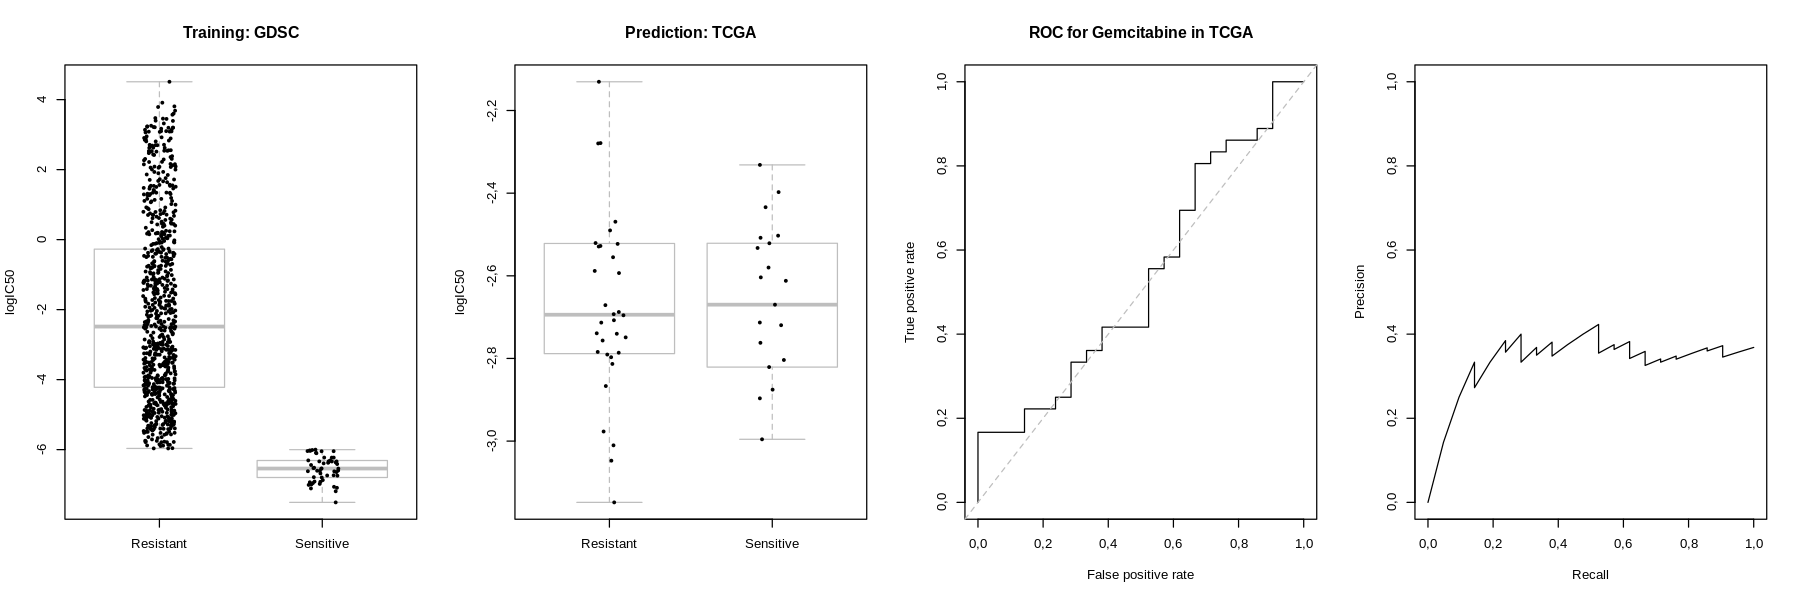

In [23]:
nmf_dir <- "NMF/"
results_table <- list()
ds_names <- c()
for (k in c('80')){
    for (pair in pairs){
        drug<- pair$"drug"
        cohort <- pair$"cohort"
        testDataFile <- paste0(nmf_dir,cohort,".multiOmics.",drug,".NMF_k=",k,".W.tsv")
        testResponseFile <- paste0(root_dir,"/response/",cohort,"_response.",drug,".tsv")
        print(testDataFile)
        trainingDataFile <- paste0(nmf_dir,"GDSC",".multiOmics.",drug,".NMF_k=",k,".W.tsv")
        trainingResponseFile <- paste0(root_dir,"/response/","GDSC","_response.",drug,".tsv")

        res <- run_Geelehers_method(testDataFile,testResponseFile,trainingDataFile,trainingResponseFile,
                               powTransP=powTransP,lowVarGeneThr=lowVarGeneThr,cohort=cohort,drug=drug)
        res <- c(res$"AUC",res$"AUC_pval",res$"AUPRC",res$"AUPRC_pval",res$"P_freq",res$"S",res$"R")
        ds_names <- c(ds_names, paste0(cohort,"_",drug,"_",k))
        results_table  <- c(results_table , list(res))
    }
}

results_table  <- plyr::ldply(results_table)
colnames(results_table) <- c("AUC","AUC_pval","AUPRC","AUPRC_pval","P_freq","S","R")
row.names(results_table) <-  ds_names


In [24]:
results_table

,AUC,AUC_pval,AUPRC,AUPRC_pval,P_freq,S,R
PDX_Paclitaxel_80,"0,6263158","0,1818","0,08606292","0,8501","0,12",5,38
PDX_Gemcitabine_80,"0,5238095","0,4223","0,37324352","0,2715","0,28",7,18
PDX_Cetuximab_80,"0,3854545","0,7956","0,10727432","0,3216","0,08",5,55
PDX_Erlotinib_80,"0,4074074","0,6598","0,15487568","0,4468","0,14",3,18
TCGA_Docetaxel_80,"0,5468750","0,3630","0,53487294","0,4553","0,50",8,8
TCGA_Cisplatin_80,"0,4777778","0,5785","0,89968445","0,6581","0,91",60,6
TCGA_Gemcitabine_80,"0,5343915","0,3310","0,33464722","0,7661","0,37",21,36


In [22]:
results_table

,AUC,AUC_pval,AUPRC,AUPRC_pval,P_freq,S,R
PDX_Paclitaxel_96,"0,4526316","0,6254","0,1183764","0,5172","0,12",5,38
PDX_Gemcitabine_96,"0,5555556","0,3266","0,3522670","0,3167","0,28",7,18
PDX_Cetuximab_96,"0,6072727","0,2143","0,0734117","0,6716","0,08",5,55
PDX_Erlotinib_96,"0,3148148","0,8209","0,2724673","0,1830","0,14",3,18
TCGA_Docetaxel_96,"0,4687500","0,5560","0,4683194","0,6610","0,50",8,8
TCGA_Cisplatin_96,"0,3944444","0,7940","0,9359195","0,2573","0,91",60,6
TCGA_Gemcitabine_96,"0,6772487","0,0107","0,2757283","0,9861","0,37",21,36


In [20]:
results_table 

,AUC,AUC_pval,AUPRC,AUPRC_pval,P_freq,S,R
PDX_Paclitaxel_64,"0,2421053","0,9677","0,21874871","0,1531","0,12",5,38
PDX_Gemcitabine_64,"0,5634921","0,3113","0,35446146","0,3214","0,28",7,18
PDX_Cetuximab_64,"0,5309091","0,4072","0,07890356","0,5924","0,08",5,55
PDX_Erlotinib_64,"0,2777778","0,8708","0,27936508","0,1772","0,14",3,18
TCGA_Docetaxel_64,"0,3906250","0,7431","0,51819535","0,5178","0,50",8,8
TCGA_Cisplatin_64,"0,4027778","0,7764","0,92684846","0,3471","0,91",60,6
TCGA_Gemcitabine_64,"0,5846561","0,1495","0,37167484","0,5483","0,37",21,36


In [12]:
sessionInfo()

R version 3.5.0 (2018-04-23)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/olya/miniconda2/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=de_DE.UTF-8       
 [3] LC_TIME=de_DE.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=de_DE.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=de_DE.UTF-8          LC_NAME=de_DE.UTF-8          
 [9] LC_ADDRESS=de_DE.UTF-8        LC_TELEPHONE=de_DE.UTF-8     
[11] LC_MEASUREMENT=de_DE.UTF-8    LC_IDENTIFICATION=de_DE.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] plyr_1.8.4            PRROC_1.3.1           MLmetrics_1.1.1      
 [4] GEOquery_2.47.18      Biobase_2.36.2        BiocGenerics_0.22.1  
 [7] ROCR_1.0-7            gplots_3.0.1          preprocessCore_1.38.1
[10] car_3.0-2             carData_3.0-2         sva_3.2